# Imports and installations

In [ ]:
!pip install -U accelerate
!pip install -U transformers
!pip install torch
!pip install catboost shap optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
# Standard library imports
import ast
import six
import sys
import json
import os

In [ ]:
# Third-party imports
import sys
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import shap
import optuna
from optuna.samplers import TPESampler
#import catboost
import nltk
import numpy as np
import pandas as pd
import torch
#from catboost import CatBoostClassifier
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, r2_score,
                             matthews_corrcoef, average_precision_score,
                             roc_curve)
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
# Fixing joblib import issue
sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
# Download the punkt tokenizer
nltk.download('punkt')

# Download stopwords for multiple languages including Russian
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# set pandas display options
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 30)

In [ ]:
pd.set_option('display.precision', 3)

In [ ]:
random_state=1

In [ ]:
joblib.__version__

'1.4.2'

# Download and preprocess data

In [ ]:
X_train, y_train = pd.read_csv('full_train_data_train.csv')['Text'],pd.read_csv('full_train_data_train.csv')['target']
X_test, y_test = pd.read_csv('full_train_data_test.csv')['Text'],pd.read_csv('full_train_data_test.csv')['target']

In [ ]:
train_data = X_train.values
train_target = y_train.values
test_data = X_test.values
test_target = y_test.values

# BioBert Full

In [ ]:
train_data = X_train.apply(generate_patient_description_from_row,axis=1).values
train_target = y_train.values
test_data = X_test.apply(generate_patient_description_from_row,axis=1).values
test_target = y_test.values

In [ ]:
torch.cuda.empty_cache()

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SampleDataset(Dataset):
    """ A simple dataset. """
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
model_name = 'alexyalunin/RuBioBERT'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
# Sample data
texts_train = train_data
labels_train = train_target

# Create a dataset and dataloader
dataset_train = SampleDataset(texts_train, labels_train, tokenizer)
dataloader_train = DataLoader(dataset_train, batch_size=8)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    auc = roc_auc_score(labels, logits[:,1])
    return {
        'auc':auc
    }

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    learning_rate = 2e-5,                  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    #load_best_model_at_end=True,
    # evaluation_strategy='epoch',
    # save_strategy='epoch',
    # metric_for_best_model='auc'
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = dataset_train,
    #eval_dataset = dataset_valid,
    compute_metrics= compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [ ]:
# Train the model
trainer.train()

Step,Training Loss
10,0.729000
20,0.701800
30,0.746100
40,0.694300
50,0.687300
60,0.686500
70,0.697200
80,0.680600
90,0.703800
100,0.706100


TrainOutput(global_step=105, training_loss=0.7017214570726668, metrics={'train_runtime': 20.8651, 'train_samples_per_second': 39.06, 'train_steps_per_second': 5.032, 'total_flos': 214435510118400.0, 'train_loss': 0.7017214570726668, 'epoch': 5.0})

In [ ]:
texts_to_predict = list(test_data)
encoded_input = tokenizer(texts_to_predict, padding=True, truncation=True, max_length=512, return_tensors='pt')
encoded_input = {k: v.to(device) for k, v in encoded_input.items()}  # Move data to GPU
outputs = model(**encoded_input)
predictions = outputs.logits[:,1]

print("Predictions:", predictions)

Predictions: tensor([-0.0563,  0.0546,  0.0622, -0.0124, -0.0211, -0.1288, -0.1050,  0.0020,
         0.0736, -0.2427, -0.0672, -0.0189,  0.1100, -0.0227,  0.0226,  0.0401,
         0.0433, -0.0114,  0.0054,  0.0661, -0.0685, -0.0493, -0.0702, -0.0419,
         0.0101, -0.0418,  0.0023, -0.1295,  0.0253, -0.1066, -0.1035, -0.0460,
         0.0106,  0.0921,  0.0118, -0.0489, -0.1300, -0.0521, -0.0488, -0.0224,
         0.0337,  0.0728, -0.1128, -0.0377,  0.0026, -0.0420, -0.0620,  0.0187,
         0.0053,  0.0023, -0.0303,  0.0221, -0.0610,  0.0164,  0.0330],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# Compute ROC AUC Score
roc_auc = roc_auc_score(test_target, torch.sigmoid(predictions.detach().cpu()))
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.5994694960212201


In [ ]:
# Create a DataFrame
preds_4_save = pd.DataFrame({
    'Text': test_data,
    'Actual Label': test_target,
    'Prob Class 1': [pred for pred in predictions.detach().cpu().numpy()]
})

# Save the DataFrame to a CSV file
preds_4_save.to_csv('biobert_predictions_full.csv', index=True)

print("DataFrame saved to 'biobert_predictions_full.csv'")

DataFrame saved to 'biobert_predictions_full.csv'


In [ ]:
df_testing = pd.read_csv('biobert_predictions_full.csv')
df_testing.head()

,Unnamed: 0,Text,Actual Label,Prob Class 1
0,0,"Пациент, 52 год, ИМТ 32.65 (ожирение), артериа...",0,-0.056
1,1,"Пациентка, 45 год, ИМТ 24.02 (нормальный вес),...",1,0.055
2,2,"Пациентка, 75 год, ИМТ 36.98 (ожирение), артер...",1,0.062
3,3,"Пациент, 57 год, ИМТ 32.41 (ожирение), артериа...",0,-0.012
4,4,"Пациентка, 55 год, ИМТ 35.25 (ожирение), артер...",0,-0.021


In [ ]:
df_testing.iloc[0]['Text']

'Пациент, 52 год, ИМТ 32.65 (ожирение), артериальное давление 132/100 мм рт. ст., частота сердечных сокращений 100 уд/мин. Давность болевого синдрома составляет 3 дня. Сегмент ST поднят на 2 мм, изменения в . Класс Killip 1. В анамнезе инфаркт миокарда отсутствует, фибрилляция предсердий отсутствует, гипертоническая болезнь отсутствует, сахарный диабет II типа, миокардиальная фиброзная атрофия (МФА). ОНМК отсутствует, стентирование или АКШ отсутствуют. Индекс коморбидности 3. Тропонин Т повышен до 648.5 нг/л. Общий холестерин 6.71 ммоль/л, гемоглобин 171 г/л, глюкоза 10.77 ммоль/л. СКФ по формуле EPI составляет 89.0 мл/мин/1,73 м², креатинин 68.0 мкмоль/л. ИКДО ЛЖ 48.08 мл/м², ИКСО ЛЖ 20.41 мл/м², фракция выброса ЛЖ 57.55%. ИММ ЛЖ 74.70 г/м², ЛП 3.9 см, ИНЛС ЛЖ 1.000. TIMI в ИЗА 1. Поражена инфаркт-зависимая артерия (1), ствол ЛКА (1), всего поражено 5 коронарных артерий. Проведено ЧКВ. Низкая степень риска (1) по статинам. VGFR2 положительный.'

In [ ]:
# Compute ROC AUC Score
roc_auc = roc_auc_score(df_testing['Actual Label'], torch.sigmoid(torch.Tensor(df_testing['Prob Class 1'].values)))
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.5994694960212201


# BioBert (SFS)

In [ ]:
X_train, y_train = pd.read_csv('full_train_data_train.csv')['Text'],pd.read_csv('full_train_data_train.csv')['target']
X_test, y_test = pd.read_csv('full_train_data_test.csv')['Text'],pd.read_csv('full_train_data_test.csv')['target']

In [ ]:
train_data = X_train.values
train_target = y_train.values
test_data = X_test.values
test_target = y_test.values

In [ ]:
torch.cuda.empty_cache()

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SampleDataset(Dataset):
    """ A simple dataset. """
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
model_name = 'alexyalunin/RuBioBERT'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
# Sample data
texts_train = train_data
labels_train = train_target

# Create a dataset and dataloader
dataset_train = SampleDataset(texts_train, labels_train, tokenizer)
dataloader_train = DataLoader(dataset_train, batch_size=8)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    auc = roc_auc_score(labels, logits[:,1])
    return {
        'auc':auc
    }

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    learning_rate = 2e-5,                  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    #load_best_model_at_end=True,
    # evaluation_strategy='epoch',
    # save_strategy='epoch',
    # metric_for_best_model='auc'
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = dataset_train,
    #eval_dataset = dataset_valid,
    compute_metrics= compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [ ]:
# Train the model
trainer.train()

Step,Training Loss
10,0.732700
20,0.694700
30,0.721600
40,0.620600
50,0.604400
60,0.599200
70,0.626700
80,0.549200
90,0.534600
100,0.595100


TrainOutput(global_step=105, training_loss=0.623143888655163, metrics={'train_runtime': 20.7988, 'train_samples_per_second': 39.185, 'train_steps_per_second': 5.048, 'total_flos': 214435510118400.0, 'train_loss': 0.623143888655163, 'epoch': 5.0})

In [ ]:
texts_to_predict = list(test_data)
encoded_input = tokenizer(texts_to_predict, padding=True, truncation=True, max_length=512, return_tensors='pt')
encoded_input = {k: v.to(device) for k, v in encoded_input.items()}  # Move data to GPU
outputs = model(**encoded_input)
predictions = outputs.logits[:,1]

print("Predictions:", predictions)

Predictions: tensor([-0.1764,  0.9811,  0.9896,  0.0023, -0.2897,  0.9748,  0.4550,  0.4563,
        -0.2850,  0.3287,  0.8810, -0.2849, -0.3025, -0.4413, -0.2150,  0.6565,
         0.3198,  0.7133, -0.1991, -0.4054,  0.5537, -0.3600, -0.2867, -0.3136,
        -0.3848,  0.0550, -0.3951,  0.2955, -0.1658,  0.2936,  0.9466, -0.2851,
         0.5680,  0.9445, -0.3169,  0.9499, -0.1168,  1.0015,  0.9684, -0.2871,
        -0.1627,  0.6253,  0.1778,  0.4699,  0.9203, -0.2170, -0.2354,  1.0385,
         0.8896,  0.1445, -0.3750, -0.2113, -0.2295, -0.2857,  0.9815],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# Compute ROC AUC Score
roc_auc = roc_auc_score(test_target, torch.sigmoid(predictions.detach().cpu()))
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.810344827586207


In [ ]:
# Create a DataFrame
preds_4_save = pd.DataFrame({
    'Text': test_data,
    'Actual Label': test_target,
    'Prob Class 1': [pred for pred in predictions.detach().cpu().numpy()]
})

# Save the DataFrame to a CSV file
preds_4_save.to_csv('biobert_predictions_sfs.csv', index=True)

print("DataFrame saved to 'biobert_predictions_sfs.csv'")

DataFrame saved to 'biobert_predictions_sfs.csv'


In [ ]:
df_testing = pd.read_csv('biobert_predictions_sfs.csv')
df_testing.head()

,Unnamed: 0,Text,Actual Label,Prob Class 1
0,0,"Пациент мужского пола. Имеется ожирение, что з...",0,-0.176
1,1,Пациент женского пола. Индекс массы тела наход...,1,0.981
2,2,"Пациент женского пола. Имеется ожирение, что з...",1,0.990
3,3,"Пациент мужского пола. Имеется ожирение, что з...",0,0.002
4,4,"Пациент женского пола. Имеется ожирение, что з...",0,-0.290


In [ ]:
df_testing.iloc[0]['Text']

'Пациент мужского пола. Имеется ожирение, что значительно увеличивает риск развития сердечно-сосудистых заболеваний и других сопутствующих заболеваний. Индекс коморбидности составляет 3, что указывает на наличие сопутствующих заболеваний и может усложнять лечение. Количество пораженных коронарной артерий: 3. Пациент принимает статины, что помогает снижать уровень холестерина и уменьшает риск сердечно-сосудистых заболеваний. Латеральная стенка левого желудочка без патологий. Имеется поражение главной левой коронарной артерии. Пациент перенес чрескожное коронарное вмешательство или шунтирование коронарных артерий. Наблюдается повышенный уровень васкулярного эндотелиального фактора роста 2, что может указывать на активный процесс ангиогенеза.'

In [ ]:
# Compute ROC AUC Score
roc_auc = roc_auc_score(df_testing['Actual Label'], torch.sigmoid(torch.Tensor(df_testing['Prob Class 1'].values)))
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.810344827586207


In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/1231_ABCD/biobert_sfs_state_dict')

In [ ]:
torch.load('/content/drive/MyDrive/1231_ABCD/biobert_sfs_state_dict')

OrderedDict([('bert.embeddings.word_embeddings.weight',
              tensor([[-0.0757, -0.0162, -0.0145,  ...,  0.0304,  0.0085,  0.0101],
                      [-0.0440,  0.0080,  0.0260,  ...,  0.0069,  0.0064, -0.0164],
                      [-0.0690, -0.0070,  0.0079,  ...,  0.0052, -0.0093,  0.0308],
                      ...,
                      [-0.0554,  0.0036, -0.0581,  ..., -0.0227,  0.0725, -0.0197],
                      [-0.0689,  0.0345,  0.0406,  ..., -0.0014, -0.0391, -0.0136],
                      [-0.0665,  0.0129, -0.0165,  ..., -0.0406, -0.0420, -0.0045]],
                     device='cuda:0')),
             ('bert.embeddings.position_embeddings.weight',
              tensor([[-0.0047, -0.0224, -0.0047,  ...,  0.0226,  0.1194,  0.0869],
                      [ 0.0059, -0.0798,  0.0049,  ...,  0.0043,  0.1299,  0.0543],
                      [ 0.0060, -0.0508,  0.0083,  ...,  0.0038,  0.0396,  0.0348],
                      ...,
                      [ 0.0082,  

# Boosting baseline

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import wordnet
from sklearn.utils import shuffle

In [ ]:
# Stopwords and stemmer for Russian
stop_words = stopwords.words('russian')
stemmer = SnowballStemmer("russian")

def is_numeric(token):
    try:
        float(token)  # Try converting the token to float
        return True
    except ValueError:
        return False

def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text, language='russian')
    # Process tokens
    processed_tokens = []
    for word in tokens:
        if is_numeric(word):  # Preserve numbers as they are important
            processed_tokens.append(word)
        elif word.isalpha() and word not in stop_words:
            processed_tokens.append(stemmer.stem(word))  # Stem only non-numeric words that are not stopwords
    return ' '.join(processed_tokens)

In [ ]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Suppose we have some sample data
texts = train_data
processed_texts = [preprocess_text(text) for text in texts]

# Fit and transform the texts
tfidf_matrix = vectorizer.fit_transform(processed_texts)

In [ ]:
from sklearn.model_selection import (GridSearchCV, KFold, ShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split, StratifiedKFold)

In [ ]:
def objective(trial):

# Define the parameters dictionary using suggestions from a hyperparameter optimization trial
  params = {
    "objective": trial.suggest_categorical("objective", ["Logloss"]),
    "iterations": trial.suggest_categorical("iterations", [1000]),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 5e-1, log=True),
    "depth": trial.suggest_int("depth", 2, 8),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 150.0, log=True),
    "random_strength": trial.suggest_float("random_strength", 1e-1, 10.0, log=True),
    "auto_class_weights": trial.suggest_categorical("auto_class_weights", [None, "Balanced", "SqrtBalanced"]),
    "verbose": False,
    "random_state": trial.suggest_categorical("random_state", [random_state]),
    "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
    "rsm": trial.suggest_float("rsm", 0.3, 1.0),
    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"])
    }

  if params["bootstrap_type"] == "Bayesian":
    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif params["bootstrap_type"] == "Bernoulli":
    params["subsample"] = trial.suggest_float("subsample", 0.1, 0.9)

  model = CatBoostClassifier(**params)

  kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  scores = cross_val_score(
        model, tfidf_matrix, train_target, cv=kfolds,
        scoring="roc_auc"
    )
  return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="catboost_genetics", direction="maximize",sampler = sampler)

study.optimize(objective, n_trials=100)

[I 2024-05-16 20:43:33,589] A new study created in memory with name: catboost_genetics
[I 2024-05-16 20:44:26,949] Trial 0 finished with value: 0.6461904761904761 and parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.003487802515319415, 'depth': 7, 'l2_leaf_reg': 0.10008367981663674, 'random_strength': 0.402406646471461, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'Lossguide', 'rsm': 0.5934361600823064, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.781174363909454}. Best is trial 0 with value: 0.6461904761904761.
[I 2024-05-16 20:44:54,562] Trial 1 finished with value: 0.6646031746031748 and parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.00012627165880121756, 'depth': 6, 'l2_leaf_reg': 2.1154274483309874, 'random_strength': 1.3103269001464433, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'SymmetricTree', 'rsm': 0.9134724066072268, 'bootstrap_type': 'Bayesian', 'bagging

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.702010582010582

Optimized parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.0003675955216104044, 'depth': 2, 'l2_leaf_reg': 1.2173380553129962, 'random_strength': 0.1648277655890433, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'SymmetricTree', 'rsm': 0.6897391961993168, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3978191785431149}



In [ ]:
# Initialize and train the CatBoost Classifier
model = CatBoostClassifier(**best_params)
model.fit(tfidf_matrix, train_target)

0:	learn: 0.6931269	total: 1.7ms	remaining: 1.69s
1:	learn: 0.6930750	total: 3.52ms	remaining: 1.76s
2:	learn: 0.6930156	total: 5.06ms	remaining: 1.68s
3:	learn: 0.6929485	total: 6.52ms	remaining: 1.62s
4:	learn: 0.6929052	total: 7.97ms	remaining: 1.59s
5:	learn: 0.6928929	total: 9.37ms	remaining: 1.55s
6:	learn: 0.6928463	total: 10.7ms	remaining: 1.52s
7:	learn: 0.6927743	total: 12.1ms	remaining: 1.5s
8:	learn: 0.6927618	total: 13.5ms	remaining: 1.48s
9:	learn: 0.6927155	total: 15ms	remaining: 1.48s
10:	learn: 0.6926940	total: 16.5ms	remaining: 1.48s
11:	learn: 0.6926327	total: 17.9ms	remaining: 1.47s
12:	learn: 0.6925968	total: 19.3ms	remaining: 1.47s
13:	learn: 0.6925539	total: 20.7ms	remaining: 1.45s
14:	learn: 0.6925006	total: 22.2ms	remaining: 1.46s
15:	learn: 0.6924561	total: 23.7ms	remaining: 1.45s
16:	learn: 0.6924205	total: 25.2ms	remaining: 1.46s
17:	learn: 0.6923677	total: 26.5ms	remaining: 1.45s
18:	learn: 0.6923184	total: 27.9ms	remaining: 1.44s
19:	learn: 0.6922752	total

In [ ]:
test_texts_processed = [preprocess_text(text) for text in test_data]
test_tfidf = vectorizer.transform(test_texts_processed)

predictions = model.predict_proba(test_tfidf)[:,1]
# Compute ROC AUC Score
roc_auc = roc_auc_score(test_target, predictions)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.6100795755968169


In [ ]:
# Create a DataFrame
preds_4_save = pd.DataFrame({
    'Text': test_data,
    'Actual Label': test_target,
    'Prob Class 1': [pred for pred in predictions]
})

# Save the DataFrame to a CSV file
preds_4_save.to_csv('catboost_predictions.csv', index=True)

In [ ]:
import joblib

In [ ]:
# Saving model
joblib.dump(model, '/content/drive/MyDrive/1231_ABCD/catboost_genetics_text.joblib')

['/content/drive/MyDrive/1231_ABCD/catboost_genetics_text.joblib']

# Bootstrapped test metrics

In [ ]:
from sklearn.metrics import auc,precision_recall_curve

In [ ]:
def evaluate_metrics(classifier_name, data, num_bootstrap=1000, random_state=random_state):
    metrics = ['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy']
    results = {}

    for clf_name in [classifier_name]:
        metric_scores = []
        for i in range(num_bootstrap):
            # Initialize random number generator
            rng = np.random.default_rng(random_state + i)

            # Bootstrap resampling
            num_samples = len(X_test)
            bootstrap_indices = rng.choice(num_samples, num_samples, replace=True)
            data_bootstrap = data.iloc[bootstrap_indices]
            y_bootstrap = data_bootstrap['Actual Label']
            # Handle the case when only one class is present in y_bootstrap
            if len(np.unique(y_bootstrap)) == 1:
                continue

            if clf_name!='ChatGPT':
              # Predict probabilities
              y_prob = data_bootstrap['Prob Class 1']

            else:
              y_prob = data_bootstrap['Prob Class 1']#data_bootstrap['Predicted outcome']

            # Calculate metrics
            y_prob_round = y_prob.round()
            pr,rec,tres = precision_recall_curve(y_bootstrap, y_prob)
            pr_auc = auc(rec,pr)
            roc_auc = roc_auc_score(y_bootstrap, y_prob)
            f1 = f1_score(y_bootstrap.values, y_prob_round)
            precision = precision_score(y_bootstrap, y_prob_round)
            recall = recall_score(y_bootstrap, y_prob_round)
            mcc = matthews_corrcoef(y_bootstrap, y_prob_round)
            accuracy = accuracy_score(y_bootstrap, y_prob_round)

            metric_scores.append((pr_auc, roc_auc, f1, precision, recall, mcc, accuracy))

        metric_scores = np.array(metric_scores)
        mean_scores = np.mean(metric_scores, axis=0)
        results[clf_name] = mean_scores

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=metrics)
    return results_df

In [ ]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [ ]:
biobert = pd.read_csv('/content/biobert_predictions_full.csv')
catboost = pd.read_csv('/content/catboost_predictions.csv')
biobert_sfs = pd.read_csv('/content/biobert_predictions_sfs.csv')
biobert['Prob Class 1'] = biobert['Prob Class 1'].apply(sigmoid)
biobert_sfs['Prob Class 1'] = biobert_sfs['Prob Class 1'].apply(sigmoid)

In [ ]:
biobert_ = evaluate_metrics('RuBioBert on full data',biobert)
catboost_ = evaluate_metrics('TF-IDF + Catboost',catboost)
biobert_sfs_ = evaluate_metrics('RuBioBert after SFS',biobert_sfs)

In [ ]:
res = pd.concat([biobert_,catboost_,biobert_sfs_])#,biobert_sfs_old_])

In [ ]:
res.round(3).sort_values(by=['ROC_AUC','PR_AUC'],ascending=False).style.highlight_max()

,PR_AUC,ROC_AUC,F1-score,Precision,Recall,MCC,Accuracy
RuBioBert after SFS,0.843000,0.811000,0.650000,0.619000,0.693000,0.315000,0.655000
TF-IDF + Catboost,0.584000,0.611000,0.601000,0.564000,0.654000,0.203000,0.598000
RuBioBert on full data,0.630000,0.601000,0.623000,0.639000,0.616000,0.307000,0.655000


# Shap values

In [ ]:
import shap

In [ ]:
# define a prediction function
def f(x):
    predictions=[]
    for text in x:
      encoded_input = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
      encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
      outputs = model(**encoded_input)
      prediction = torch.sigmoid(outputs.logits[:,1]).detach().cpu().numpy()
      predictions.append(prediction)
    predictions = np.concatenate(predictions)

    return predictions

In [ ]:
texts_to_predict = list(train_data)
encoded_input = tokenizer(texts_to_predict, padding=True, truncation=True, max_length=512, return_tensors='pt')
encoded_input = {k: v.to(device) for k, v in encoded_input.items()}  # Move data to GPU
outputs = model(**encoded_input)
predictions = torch.sigmoid(outputs.logits[:,1]).detach().cpu().numpy()
min_index = np.argmin(predictions)
max_index = np.argmax(predictions)

In [ ]:
print(min_index)
print(max_index)

29
156


In [ ]:
explainer = shap.Explainer(f, tokenizer)

In [ ]:
shap_values = explainer(train_data, fixed_context=1)

PartitionExplainer explainer: 164it [08:12,  3.08s/it]


In [ ]:
help(shap.plots.text)

In [ ]:
shap.plots.text(shap_values[max_index], grouping_threshold=10, xmin=0.49, xmax=0.8)

In [ ]:
shap.plots.text(shap_values[min_index], grouping_threshold=10, xmin=0.35, xmax=0.62)

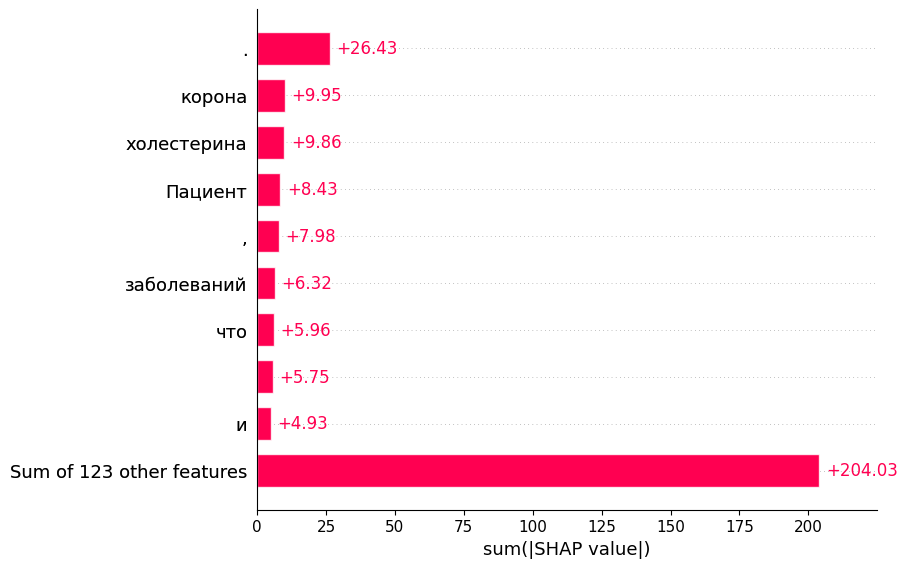

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))

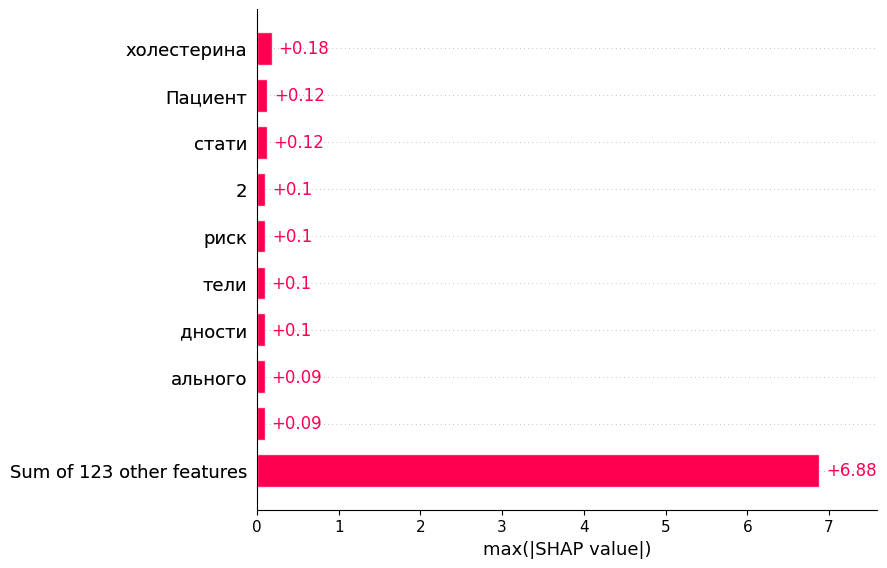

In [ ]:
shap.plots.bar(shap_values.abs.max(0))

# General

In [ ]:
res_for_graph = res.round(3).sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

In [ ]:
res = pd.DataFrame()
res['model_name'] = res_for_graph.index.values
res['ROC_AUC'] = res_for_graph['ROC_AUC'].values
res['models'] = ['Conventional','Conventional','Conventional']

In [ ]:
fig = px.bar(res,
                   y='model_name',
                   x='ROC_AUC',
                   #title='Model Comparison by AUROC',
                  #color = 'models',
                   text='ROC_AUC',
                   labels={'table_name': 'Dataset', 'ROC_AUC': 'AUROC', 'model_name': 'Model'})
# Add ROC AUC values inside bins
fig.update_traces(marker_line_width=0.5, textposition='inside', texttemplate='%{text:.3f}',textfont=dict(color='black'))

# Remove axis and legend inscriptions
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')
fig.update_layout(legend_title_text='', yaxis={'categoryorder':'total ascending'})

# Update axis labels
fig.update_layout(yaxis_title='Model Names', xaxis_title='AUROC')
# Show the plot
fig.show()